### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

#### Задание:
 Используя данные из train.csv, построить
 модель для предсказания цен на недвижимость (квартиры).
 С помощью полученной модели предсказать
 цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [79]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

## 1. Загрузка данных, изучение

In [50]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [3]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [4]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


- необходимо восстановить LifeSquare и проверить разницу жилой площади и общей
- необходимо восстановить Healthcare_1
- "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных
- столбец Id не будем использовать при построении моделей
- проверить площадь кухни против площадь жилая
- проверить количество этажей в доме
- проверить год постройки

In [39]:
# LifeSqaure - сколько необходимо восстановить
print('LifeSqaure missed   - ', pd.isna(df['LifeSquare']).value_counts()[1])
print('LifeSqaure wrong    - ', (df['LifeSquare']-df['Square']>0).value_counts()[1])

print('Healthcare_1 missed - ', pd.isna(df['Healthcare_1']).value_counts()[1])
print('KitchenSquare wrong - ', (df['KitchenSquare']-df['LifeSquare']>0).value_counts()[1])
print('HouseFloor wrong    - ', (df['HouseFloor']-df['Floor']<0).value_counts()[1])
print('HouseYear wrong     - ', df['HouseYear'].sort_values()[-2:].to_list())

LifeSqaure missed   -  2113
LifeSqaure wrong    -  482
Healthcare_1 missed -  4798
KitchenSquare wrong -  23
HouseFloor wrong    -  1825
HouseYear wrong     -  [4968, 20052011]


Восстанавливаем от большего количества пропущенных значений к меньшему.
0. Преобразуем категории в числовые
1. HouseYear - всего два значения
2. HealthCare_1
3. LifeSquare
4. HouseFloor
5. KitchenSquare

## 2. Восстанавливаем

### 2.0. Признаки "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных

In [59]:
# df.info()
df = pd.get_dummies(df)
# df.info()

### 2.1. HouseYear

In [51]:
df['HouseYear'].sort_values().tail(2)

4189        4968
1497    20052011
Name: HouseYear, dtype: int64

In [57]:
print('Медиана: ',int(round(df['HouseYear'].agg('median'))))
df.iloc[4189,8] = (int(round(df['HouseYear'].agg('median'))))
df.iloc[1497,8] = (int(round(df['HouseYear'].agg('median'))))
df.iloc[4189,8] = (int(round((df[df['DistrictId']==147].agg({'HouseYear': 'mean'})))))
df.iloc[1497,8] = (int(round(df[df['DistrictId']==109].agg({'HouseYear': 'mean'}))))
#print(df.iloc[1497,:]['DistrictId'])
#print(df.iloc[4189,:]['DistrictId'])
print('Среднее значение для региона 147', int(round((df[df['DistrictId']==147].agg({'HouseYear': 'mean'})))))
print('Среднее значение для региона 109', int(round(df[df['DistrictId']==109].agg({'HouseYear': 'mean'}))))

Медиана:  1977
Среднее значение для региона 147 1969
Среднее значение для региона 109 1986


### 2.2. HealthCare_1

In [60]:
df_hc = df.copy()

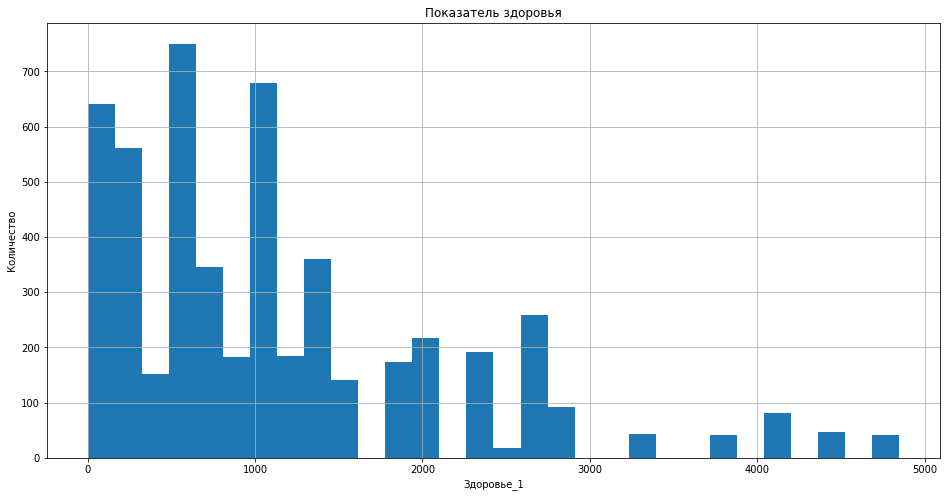

In [62]:
plt.figure(figsize = (16, 8))

df_hc['Healthcare_1'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Здоровье_1')

plt.title('Показатель здоровья')
plt.show()

In [65]:
df_hc = df_hc[pd.isna(df_hc['Healthcare_1'])==False].reset_index()
df_hc.drop(['index'], axis=1, inplace=True)

In [66]:
feature_ = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
            'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
            'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A', 'Ecology_2_B',
            'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']
target_ = 'Healthcare_1'

In [68]:
feature_std = df_hc[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

In [71]:
scl = StandardScaler()
scl_f = scl.fit_transform(df_hc[feature_std])

In [74]:
df_hc[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df_hc[feature_]
y = df_hc[target_]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)
#X.describe()

**Linear Regression**

R2:	0.175
MAE:	672.978
MSE:	864086.49


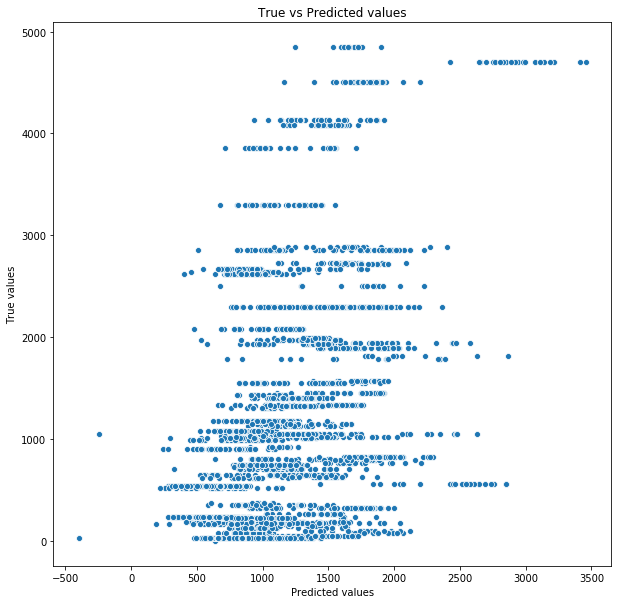

R2:	0.17
MAE:	661.667
MSE:	851394.928


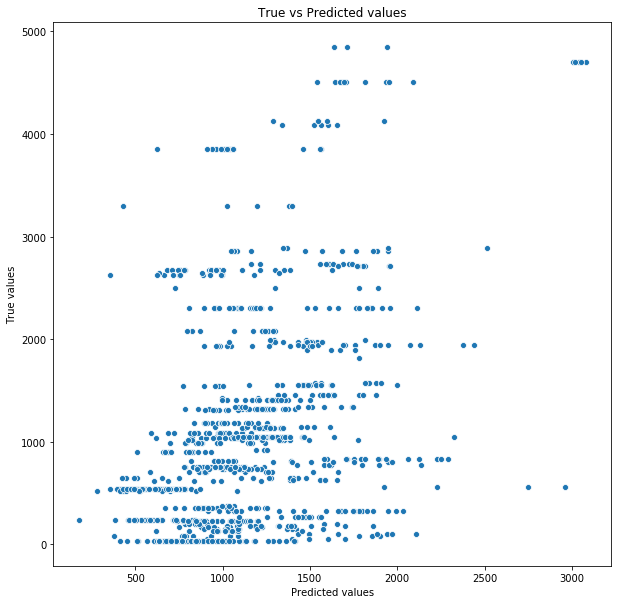

In [80]:
model_l = LinearRegression()
model_l.fit(X_train, y_train)

y_pred_l = model_l.predict(X_train)
evaluate_preds(y_train, y_pred_l)

y_pred_lt = model_l.predict(X_test)
evaluate_preds(y_test, y_pred_lt)

**Random Forest**

R2:	0.999
MAE:	3.698
MSE:	1070.636


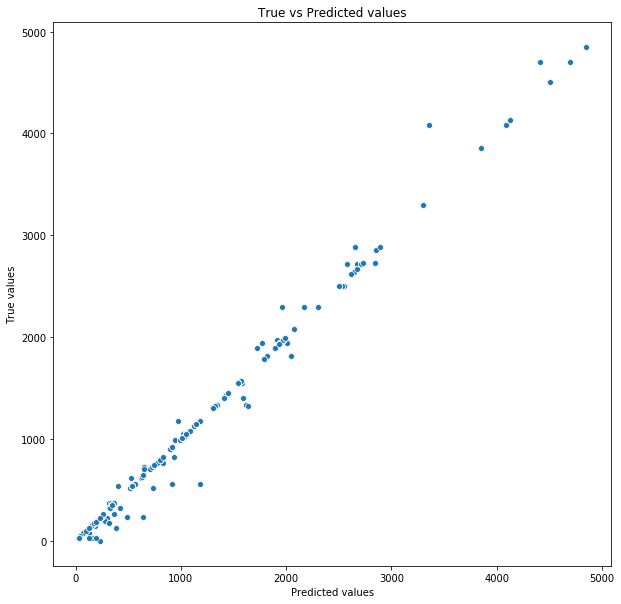

R2:	0.994
MAE:	8.065
MSE:	6020.947


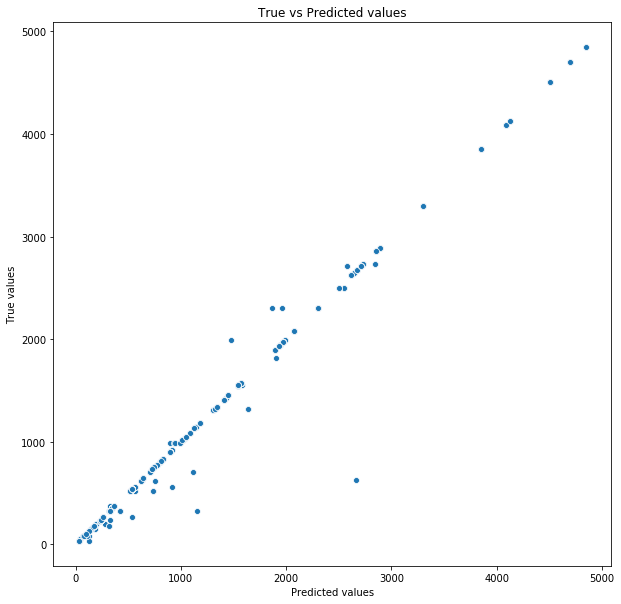

In [81]:
model_r = RandomForestRegressor()
model_r.fit(X_train, y_train)

y_pred_r = model_r.predict(X_train)
evaluate_preds(y_train, y_pred_r)

y_pred_rt = model_r.predict(X_test)
evaluate_preds(y_test, y_pred_rt)

**Gradient Boosting**

R2:	0.965
MAE:	129.303
MSE:	36834.435


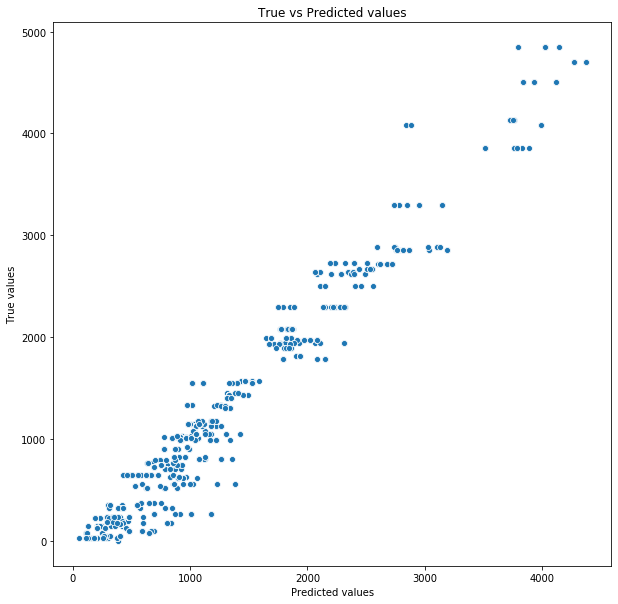

R2:	0.964
MAE:	128.497
MSE:	37150.724


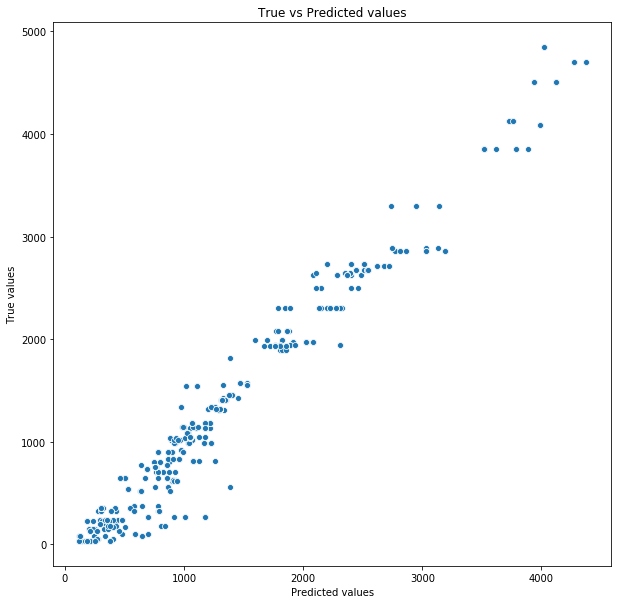

In [82]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_train)
evaluate_preds(y_train, y_pred_gb)

y_pred_gbt = model_gb.predict(X_test)
evaluate_preds(y_test, y_pred_gbt)

**Выбираем Random Forest**

In [86]:
df_hc_m = df.copy()
df_hc_m = df_hc_m[pd.isna(df_hc_m['Healthcare_1'])==True].reset_index()
df_hc_m.drop(['index'], axis=1, inplace=True)
df_hc_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 23 columns):
Id               4798 non-null int64
DistrictId       4798 non-null int64
Rooms            4798 non-null float64
Square           4798 non-null float64
LifeSquare       3430 non-null float64
KitchenSquare    4798 non-null float64
Floor            4798 non-null int64
HouseFloor       4798 non-null float64
HouseYear        4798 non-null int64
Ecology_1        4798 non-null float64
Social_1         4798 non-null int64
Social_2         4798 non-null int64
Social_3         4798 non-null int64
Healthcare_1     0 non-null float64
Helthcare_2      4798 non-null int64
Shops_1          4798 non-null int64
Price            4798 non-null float64
Ecology_2_A      4798 non-null uint8
Ecology_2_B      4798 non-null uint8
Ecology_3_A      4798 non-null uint8
Ecology_3_B      4798 non-null uint8
Shops_2_A        4798 non-null uint8
Shops_2_B        4798 non-null uint8
dtypes: float64(8), int64(9),

In [93]:
df_hc_m_std = df_hc_m.copy()
scl_f = scl.transform(df_hc_m_std[feature_std])
df_hc_m_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

X = df_hc_m_std[feature_]
healthcare_1 = model_r.predict(X)
df_hc_m[target_] =  pd.DataFrame(healthcare_1)

In [95]:
df_ = pd.concat([df[pd.isna(df['Healthcare_1'])==False], df_hc_m], ignore_index=True)
df_ = df_[['Id'] + feature_[0:3] + ['LifeSquare'] + feature_[3:-9] + [target_] + feature_[-9:]]
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dty